Notebook where to plot the curves and display the performance of all models in 
a chosen folder. It is also where to conduct the performance analysis about the
models database.

In [158]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, ttest_1samp
from sklearn.linear_model import LinearRegression

from contrastive.utils.models_database import import_bdd

## Functions

In [159]:
def import_and_filter(database_path):
    bdd = import_bdd(database_path, verbose=True)
    bdd.sort_values(by='auc', inplace=True)
    bdd = bdd[bdd.exclude == 'False']
    bdd = bdd[~(~(bdd.model_path.str.contains("joel")) & (bdd.backbone_name == "densenet"))]
    return bdd

In [160]:
database_path = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/summary/bdd_gridsearch-HCP-half-1_evaluation-ACCpatterns-0.csv"
save_fig_path = "/host/home/jc225751/Nextcloud/Travail/05 - Articles/IPMI_2023/figures"

## Use the database: evaluated on ACCpatterns-0

In [161]:
bdd = pd.read_csv(database_path, index_col=0)
bdd[bdd.exclude != 'bad_learning'].groupby(['num_representation_features','backbone_name', 'foldlabel']).count()

model_path  auc  auc_std  \
num_representation_features backbone_name foldlabel                             
4                           convnet       False              10   10       10   
                                          True                5    5        5   
                            densenet      False              15   15       15   
                                          True               14   14       14   
                            pointnet      False               8    8        8   
                                          True               17   17       17   
10                          convnet       False               5    5        5   
                                          True                5    5        5   
                            densenet      False               5    5        5   
                                          True                5    5        5   
                            pointnet      False               5    5        5   
                                          True                5    5        5   
12                          pointnet      False               1    1        1   
30                          convnet       False               6    6        6   
                                          True                9    9        9   
                            densenet      False              12   12       12   
                                          True               14   14       14   
                            pointnet      False              10   10       10   
                                          True               21   21       21   

                                                     accuracy  accuracy_std  \
num_representation_features backbone_name foldlabel                           
4                           convnet       False            10            10   
                                          True              5             5   
                            densenet      False            15            15   
                                          True             14            14   
                            pointnet      False             8             8   
                                          True             17            17   
10                          convnet       False             5             5   
                                          True              5             5   
                            densenet      False             5             5   
                                          True              5             5   
                            pointnet      False             5             5   
                                          True              5             5   
12                          pointnet      False             1             1   
30                          convnet       False             6             6   
                                          True              9             9   
                            densenet      False            12            12   
                                          True             14            14   
                            pointnet      False            10            10   
                                          True             21            21   

                                                     batch_size  dataset_name  \
num_representation_features backbone_name foldlabel                             
4                           convnet       False              10            10   
                                          True                5             5   
                            densenet      False              15            15   
                                          True               14            14   
                            pointnet      False               8             8   
                                          True               17            17   
10                          convnet       F

In [162]:
bdd = import_and_filter(database_path)

path /neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/summary/bdd_gridsearch-HCP-half-1_evaluation-ACCpatterns-0.csv
0 have been removed for bad learning


### Performance histogram

In [163]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 10, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.537, 0.097]
pca10 = [0.548, 0.074]
pca30 = [0.587, 0.055]

pca = [pca4[0], pca10[0], pca30[0]]
std_pca = [pca4[1], pca10[1], pca30[1]]

bdd_05 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]
bdd_05 = bdd_05[bdd_05.num_representation_features != 12]
bdd_15 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.15)]

clean_bdd = bdd_05

In [164]:
len(clean_bdd)

103

In [165]:
def performance_histogram(bdd, main, x, y, filters, colors=['r', 'b', 'g'], extended=True):
    n_x = len(x)
    n_y = len(y)
    
    plt.figure()
    bins = np.arange(0.45, 0.71, step=0.01)

    for i,element in enumerate(main):
        filtered_bdd = bdd[(bdd[filters[0]] == element) & ~(bdd.model_path.str.contains('unfinished'))]
        print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
        plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
        plt.xlabel('auc')
    
    if main == dimensions:
        ax = plt.gca()
        y_min, y_max = ax.get_ylim()
        plt.vlines(pca4[0], ymin=y_min, ymax=y_max, colors='blue')
        plt.vlines(pca10[0], ymin=y_min, ymax=y_max, colors='red')
        plt.vlines(pca30[0], ymin=y_min, ymax=y_max, colors='green')

    
    if main == foldlabels:
        plt.legend(["no_foldlabel", "foldlabel"])
    elif main == backbones:
        plt.legend(["convnet", "densenet", "pointnet"])
    elif main == dimensions:
        plt.legend(['pca (dim=4)', 'pca (dim=10)', 'pca (dim=30)'] + main, loc='upper left')
    plt.show()

    if extended:
        plt.figure(figsize=(n_y*6.4, n_x*4.8))

        for j in range(n_x):
            for k in range(n_y):
                pre_filtered_bdd = bdd[(bdd[filters[1]] == x[j]) & (bdd[filters[2]] == y[k])]
                print(x[j], y[k])
                plt.subplot(n_x, n_y, k + n_y*j + 1)
                for i,element in enumerate(main):
                    filtered_bdd = pre_filtered_bdd[(pre_filtered_bdd[filters[0]] == element) & ~(pre_filtered_bdd.model_path.str.contains('unfinished'))]
                    print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
                    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
                    plt.xlabel('auc')
                    plt.title(str(x[j])+' '+ str(y[k]))
                print()
                plt.legend(main)
        plt.show()

convnet, N = 35, mean performance: 0.6931484828160885
densenet, N = 30, mean performance: 0.62129243609807
pointnet, N = 38, mean performance: 0.6234582893426479


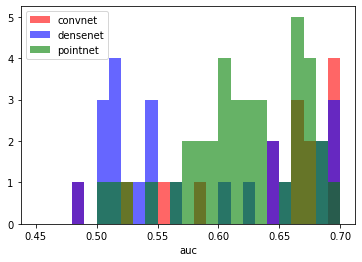

In [166]:
performance_histogram(clean_bdd, backbones, foldlabels, dimensions, filters=['backbone_name', 'foldlabel', 'num_representation_features'],
                      extended=False)

False, N = 52, mean performance: 0.6184139772590476
True, N = 51, mean performance: 0.6751540815501046


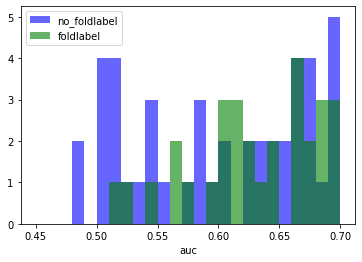

In [167]:
performance_histogram(clean_bdd, foldlabels, dimensions, backbones, filters=['foldlabel', 'num_representation_features', 'backbone_name'],
                      colors=['b', 'g'], extended=False)

4, N = 37, mean performance: 0.6158385222610575
10, N = 30, mean performance: 0.6558840992080429
30, N = 36, mean performance: 0.6702176854618169


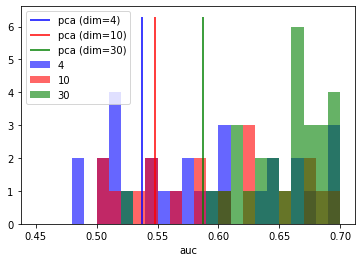

In [168]:
performance_histogram(clean_bdd, dimensions, foldlabels, backbones, filters=['num_representation_features', 'foldlabel', 'backbone_name'],
                      colors=['b', 'r', 'g'], extended=False)

### Results tables

In [169]:
def significance_over_pca(backbone, foldlabel, dim, bdd=clean_bdd):
    filtered_df = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel) & (bdd.num_representation_features == dim)]
    aucs = filtered_df.auc
    if dim == 4:
        pca = pca4
    elif dim == 10:
        pca = pca10
    elif dim == 30:
        pca = pca30
    else:
        raise ValueError('Not a dimension the PCA is evaluated for')
    
    return ttest_1samp(aucs, pca[0])

In [170]:
def compute_results_tables(clean_bdd):
    idx = ['no foldlabel 4', 'foldlabel 4', 'no_foldlabel_10', 'foldlabel_10', 'no foldlabel 30', 'foldlabel 30']

    size_rows = len(dimensions)*len(foldlabels)
    df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)
    std_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)
    count_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones, dtype=int)
    p_values_df = pd.DataFrame(np.zeros((size_rows,3)), index=idx, columns=backbones)

    for backbone in backbones:
        i = 0
        for dim in dimensions:
            for foldlabel in foldlabels:
                filtered_bdd = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
                df[backbone][i] = filtered_bdd.auc.mean()
                std_df[backbone][i] = filtered_bdd.auc.std()
                count_df[backbone][i] =  filtered_bdd.count()[0]
                p_values_df[backbone][i] = significance_over_pca(backbone, foldlabel, dim, bdd=clean_bdd)[1]
                i+=1
    return df, std_df, count_df

df, std_df, count_df = compute_results_tables(clean_bdd=clean_bdd)

df

,convnet,densenet,pointnet
no foldlabel 4,0.642624,0.511710,0.566436
foldlabel 4,0.738893,0.574877,0.653466
no_foldlabel_10,0.720243,0.522744,0.598805
foldlabel_10,0.751668,0.721450,0.620394
no foldlabel 30,0.694047,0.657710,0.647987
foldlabel 30,0.661940,0.739264,0.647554


In [171]:
clean_bdd.head()

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
164,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480100,0.073433,0.515106,6.271079e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,NaN,Run_03_aymeric
42,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.480423,0.006309,0.582353,0.000000e+00,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,0.990265,Run_03_aymeric
165,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.502669,0.059634,0.527882,5.158270e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,3.163776,3.043474,False,NaN,Run_03_aymeric
140,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508278,0.044007,0.522635,4.783800e-02,densenet,16,cingulate_HCP_half_1,0.05,100,...,251,10,10,0.1,0.1,0.806914,1.108339,False,NaN,Run_03_aymeric
40,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.508307,0.011411,0.552941,1.110223e-16,pointnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,4.103910,3.400006,False,-0.896763,pointnet


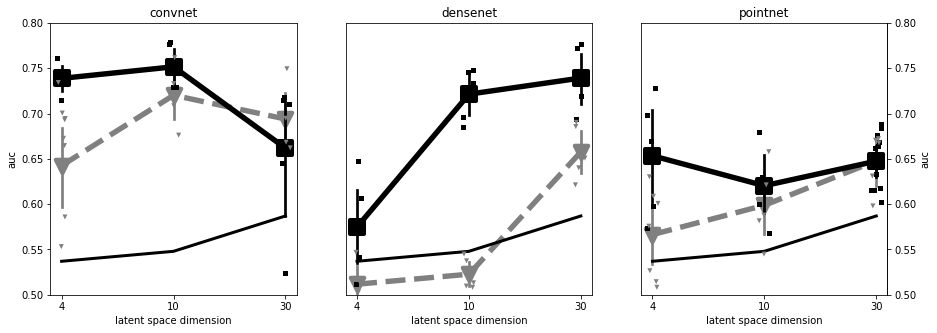

In [198]:
def plotting(clean_bdd, fig_name):
    clean_bdd['num_representation_features'] = clean_bdd['num_representation_features'].astype(str)
    f, axs = plt.subplots(1, 3, figsize=(15, 5))
    index = ['4','10','30']
    backbones = ["convnet", "densenet", "pointnet"]
    for ax, backbone in zip(axs, backbones):
        sns.pointplot(data=clean_bdd[clean_bdd.backbone_name==backbone], x=clean_bdd.num_representation_features, y="auc", hue = "foldlabel", palette=['grey', 'black'], markers=['v', 's'], scale=2, linestyles=['--', '-'], ax=ax)
        sns.stripplot(data=clean_bdd[(clean_bdd.backbone_name==backbone) & (clean_bdd.foldlabel==True)], x=clean_bdd.num_representation_features, y="auc", hue = "foldlabel", marker='s', palette=['black'], jitter=.05, ax=ax)
        sns.stripplot(data=clean_bdd[(clean_bdd.backbone_name==backbone) & (clean_bdd.foldlabel==False)], x=clean_bdd.num_representation_features, y="auc", hue = "foldlabel", marker='v', palette=['grey'], jitter=.05, ax=ax)
        ax.plot(index, pca, color='black', linewidth=3)
        ax.set_title(backbone)
        ax.set_xlabel("latent space dimension")
        if backbone != "convnet":
            ax.set_ylabel("")
            ax.set_yticks([])
        if backbone == "pointnet":
            secax = ax.secondary_yaxis('right')
            secax.set_ylabel('auc')
        ax.legend([],[], frameon=False)
        ax.set_ylim([0.5,0.8])
    plt.savefig(save_fig_path + "/" + fig_name)

plotting(clean_bdd=clean_bdd, fig_name="gridsearch.svg")

In [173]:
std_df

,convnet,densenet,pointnet
no foldlabel 4,0.078860,0.024160,0.049686
foldlabel 4,0.016590,0.053402,0.065810
no_foldlabel_10,0.031458,0.017226,0.042754
foldlabel_10,0.024596,0.029230,0.041121
no foldlabel 30,0.034445,0.029689,0.032650
foldlabel 30,0.083000,0.035044,0.031430


In [174]:
count_df

,convnet,densenet,pointnet
no foldlabel 4,10,5,7
foldlabel 4,5,5,5
no_foldlabel_10,5,5,5
foldlabel_10,5,5,5
no foldlabel 30,5,5,5
foldlabel 30,5,5,11


In [175]:
print(pca4[0], pca10[0], pca30[0])
p_values_df

0.537 0.548 0.587


,convnet,densenet,pointnet
no foldlabel 4,0.000019,0.079325,0.168051
foldlabel 4,0.000011,0.187929,0.016716
no_foldlabel_10,0.000256,0.030544,0.056560
foldlabel_10,0.000050,0.000186,0.017008
no foldlabel 30,0.002253,0.005983,0.013955
foldlabel 30,0.113637,0.000628,0.000079


## Database: evaluated on ACCpatterns-1

In [176]:
database1_path = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/summary/bdd_gridsearch-HCP-half-1_evaluation-ACCpatterns-1.csv"

In [177]:
bdd1 = import_and_filter(database_path=database1_path)

path /neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/summary/bdd_gridsearch-HCP-half-1_evaluation-ACCpatterns-1.csv
0 have been removed for bad learning


In [183]:
bdd1 = bdd1[~(bdd1["num_representation_features"] == "12")]

In [179]:
bdd1.head()

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,dataset_name,drop_rate,early_stopping_patience,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
96,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.396715,0.018044,0.458316,5.829257e-03,pointnet,16,cingulate_HCP_full,0.05,100,...,250,4,4,0.5,0.5,4.576673,4.585703,False,-0.169450,pointnet
122,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.404740,0.014289,0.533684,5.941935e-03,pointnet,16,cingulate_HCP_half_1,0.05,100,...,250,4,4,0.1,0.1,3.744332,3.345133,False,-0.757010,pointnet
24,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.414563,0.007084,0.499743,2.912633e-03,pointnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,4.296303,4.694032,False,0.708096,pointnet
31,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.431604,0.002535,0.508749,6.401840e-04,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,0.998111,Run_03_aymeric
40,/neurospin/dico/data/deep_folding/papers/ipmi2...,0.436444,0.015508,0.538012,1.110223e-16,convnet,16,cingulate_HCP_half_1,0.05,100,...,251,4,4,0.1,0.1,6.863671,6.433455,False,0.990265,Run_03_aymeric


In [180]:
# df1, std_df1, count_df1 = compute_results_tables(bdd1)

In [181]:
# df1

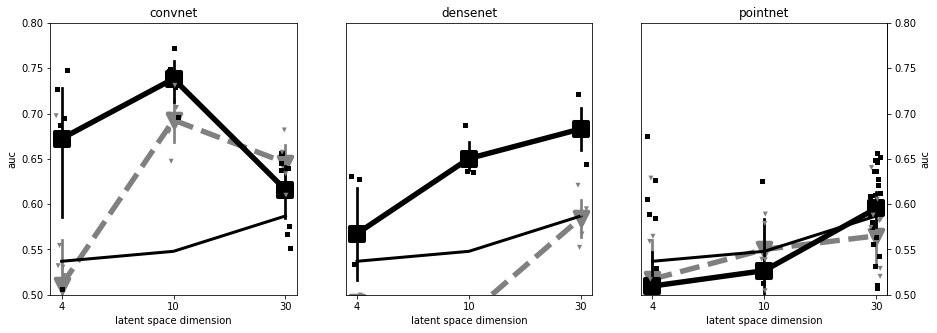

In [199]:
plotting(clean_bdd=bdd1, fig_name="gridsearch_ACC1.svg")